<a href="https://colab.research.google.com/github/SiyuFang/STAT6289/blob/master/HW4_Fang_Siyu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use DCGAN to generate photorealistic images
source:https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html#Set-training-parameters
## Importing libraries

In [ ]:
from __future__ import print_function
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

!pip install mxnet-cu100
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np

     |████████████████████████████████| 827.8MB 21kB/s 


## Set training parameters

In [ ]:
epochs = 50
batch_size = 64
latent_z_size = 100

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5

## Download and preprocess the LWF Face Dataset
The LWF Face Dataset contains roughly 13000 images of faces

In [ ]:
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

First, we resize images to size 64×64. Then, we normalize all pixel values to the [−1,1] range.



In [ ]:
target_wd = 64
target_ht = 64
img_list = []

def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3)
    # to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

Visualize 4 images:

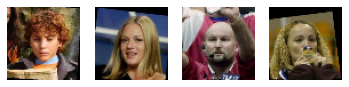

In [ ]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

## Defining the networks
### Generator
The generator, G, is designed to map the latent space vector (z) to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of [−1,1]. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below:
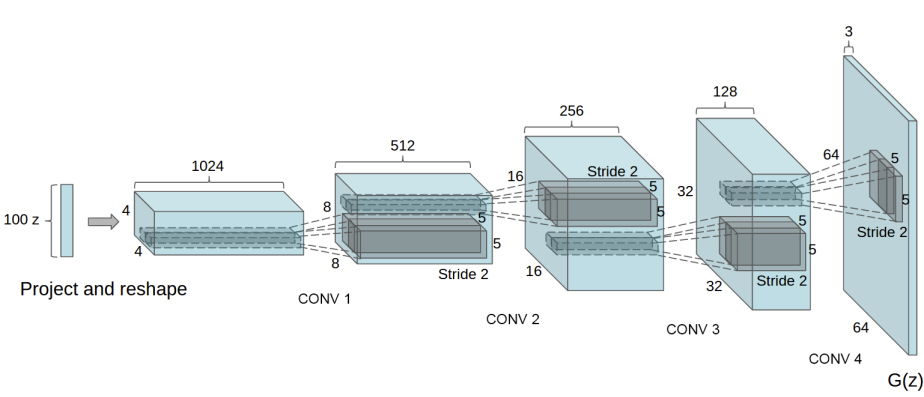

In [ ]:
# build the generator
nc = 3
ngf = 64
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

### Discriminator
The discriminator, D, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here, D takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both G and D.
The overall architecture of the model is shown as follows:
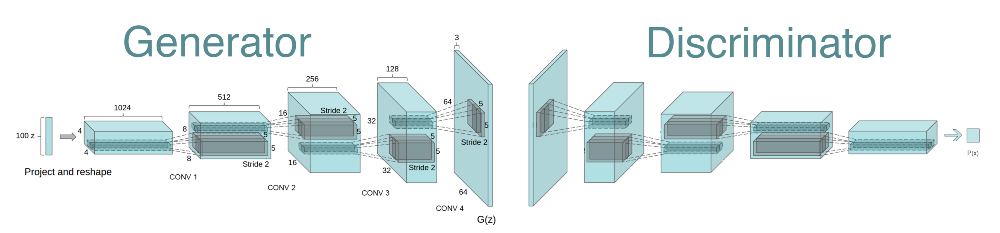

In [ ]:
# build the discriminator
ndf = 64
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

## Setup Loss Function and Optimizer
We use binary cross-entropy as our loss function and use the Adam optimizer. We initialize the network’s parameters by sampling from a normal distribution.

In [ ]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

## Training Loop
Part 1 - Train the Discriminator

The goal of training the discriminator is to maximize the probability of correctly classifying a given input as real or fake. In terms of Goodfellow, we wish to “update the discriminator by ascending its stochastic gradient”. Practically, we want to maximize log(D(x))+log(1−D(G(z))). Due to the separate mini-batch suggestion from ganhacks, we will calculate this in two steps. First, we will construct a batch of real samples from the training set, forward pass through D, calculate the loss (log(D(x))), then calculate the gradients in a backward pass. Secondly, we will construct a batch of fake samples with the current generator, forward pass this batch through D, calculate the loss (log(1−D(G(z)))), and accumulate the gradients with a backward pass. Now, with the gradients accumulated from both the all-real and all-fake batches, we call a step of the Discriminator’s optimizer.

Part 2 - Train the Generator

We want to train the Generator by minimizing log(1−D(G(z))) in an effort to generate better fakes. As mentioned, this was shown by Goodfellow to not provide sufficient gradients, especially early in the learning process. As a fix, we instead wish to maximize log(D(G(z))). In the code we accomplish this by: classifying the Generator output from Part 1 with the Discriminator, computing G’s loss using real labels as GT, computing G’s gradients in a backward pass, and finally updating G’s parameters with an optimizer step. It may seem counter-intuitive to use the real labels as GT labels for the loss function, but this allows us to use the log(x) part of the BCELoss (rather than the log(1−x) part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each epoch we will push our fixed_noise batch through the generator to visually track the progress of G’s training. The training statistics reported are:
*   Loss_D - discriminator loss calculated as the sum of losses for the all real and all fake batches (log(D(x))+log(D(G(z)))).
Loss_G - generator loss calculated as log(D(G(z)))
*   Loss_G - generator loss calculated as log(D(G(z)))


*   D(x) - the average output (across the batch) of the discriminator for the all real batch. This should start close to 1 then theoretically converge to 0.5 when G gets better.
*   D(G(z)) - average discriminator outputs for the all fake batch. The first number is before D is updated and the second number is after D is updated. These numbers should start near 0 and converge to 0.5 as G gets better.

In [ ]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batch.data[0].as_in_context(ctx)
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

        with autograd.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])
            
            # train with fake image
            fake = netG(latent_z)
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])

        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    # logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    # logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch
    # fake_img = fake[0]
    # visualize(fake_img)
    # plt.show()

INFO:root:speed: 98.8132767771985 samples/s
INFO:root:discriminator loss = 1.591534, generator loss = 5.688004, binary training acc = 0.523438 at iter 0 epoch 0
INFO:root:speed: 919.5451387699454 samples/s
INFO:root:discriminator loss = 0.346761, generator loss = 10.693550, binary training acc = 0.905540 at iter 10 epoch 0
INFO:root:speed: 945.4183064314468 samples/s
INFO:root:discriminator loss = 2.315378, generator loss = 21.739506, binary training acc = 0.906622 at iter 20 epoch 0
INFO:root:speed: 946.0947238571882 samples/s
INFO:root:discriminator loss = 0.042904, generator loss = 11.040888, binary training acc = 0.905746 at iter 30 epoch 0
INFO:root:speed: 921.9326981859145 samples/s
INFO:root:discriminator loss = 0.874749, generator loss = 21.501024, binary training acc = 0.913300 at iter 40 epoch 0
INFO:root:speed: 975.2706926995153 samples/s
INFO:root:discriminator loss = 0.055038, generator loss = 9.654593, binary training acc = 0.919118 at iter 50 epoch 0
INFO:root:speed: 923

## Results
Given a trained generator, we generate some images of faces.

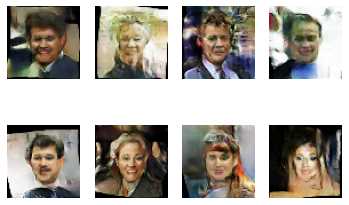

In [ ]:
num_image = 8
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    img = netG(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()

## what I learned from this implementation

I learned how to generate photo-realistic images from this implementation. At the beginning, when I tried to install and import mxnet, I didn't download the gpu version mxnet-cu100, and it caused error. And I learned the discriminator model is given images as input and must classify them as either real (from the dataset) or fake (generated). During the training process, the discriminator must grow to support images with ever-increasing size. 